**bold text**# Matrix Factorization Techniques for Context Aware Recommendation - RecSys 


**By:**  

Itay Hanya, 311446876  
Moshe Nagar, 207983867
<br><br>

# Introduction

**Prerequisites**

In [1]:
!pip install --quiet zipfile36

**Imports**

In [2]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# metrics - do not use these metrics, but you can use them to check your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# notebook
from IPython.display import FileLink, display

# Google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
warnings.filterwarnings('ignore')

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
random.seed(123)

# Data exploration


In [13]:
# dir_path = './drive/MyDrive/RecSys'
!git clone https://github.com/mosesnagar/RecSys-CAMF.git
!cd RecSys-CAMF/datasets/
dir_path ='RecSys-CAMF/datasets/'

rating_cols = ['user_id', 'movie_id', 'rating', 'normalized_rating']
user_cols = ['user_id', 'birthday', 'gender']
movie_cols = ['movie_id', 'title', 'release_date', 'geners', 'gnpp', 'average_rating', 'rated_users']
movie_usecols = [0,1,6,9,30,31,32]

def datafile_path(name):
  return dir_path + '/' + 'ydata-' + name + '.txt'

fatal: destination path 'RecSys-CAMF' already exists and is not an empty directory.


In [14]:
df_ratings_test = pd.read_csv(datafile_path('ratings-test'), delimiter='\t', header=None, names=rating_cols)
print(df_ratings_test.shape)
df_ratings_test

(10136, 4)


,user_id,movie_id,rating,normalized_rating
0,5,1808405757,9,4
1,6,1800247298,12,5
2,6,1805540029,11,5
3,6,1804090611,12,5
4,6,1800019304,12,5
...,...,...,...,...
10131,7632,1804738128,12,5
10132,7632,1808405417,12,5
10133,7632,1808405428,10,4
10134,7638,1800353825,13,5


In [15]:
df_ratings_train = pd.read_csv(datafile_path('ratings-train'), delimiter='\t', header=None, names=rating_cols)
print(df_ratings_train.shape)
df_ratings_train

(211231, 4)


,user_id,movie_id,rating,normalized_rating
0,1,1800029049,12,5
1,1,1804857429,8,4
2,1,1800030906,13,5
3,1,1800018548,11,5
4,1,1800256362,9,4
...,...,...,...,...
211226,7642,1808405417,11,5
211227,7642,1807839027,8,4
211228,7642,1808405428,11,5
211229,7642,1808429384,10,4


In [16]:
df_users = pd.read_csv(datafile_path('users'), delimiter='\t', header=None, names=user_cols)
print(df_users.shape)
df_users

(7642, 3)


,user_id,birthday,gender
0,1,1979,f
1,2,1987,m
2,3,1988,f
3,4,1983,m
4,5,1988,m
...,...,...,...
7637,7638,1975,f
7638,7639,1986,m
7639,7640,1983,f
7640,7641,1985,m


In [17]:
df_movies = pd.read_csv(datafile_path('movies'), delimiter='\t', header=None, encoding="ISO-8859-1", names=movie_cols, usecols=movie_usecols)
print(df_movies.shape)
df_movies

(106959, 7)


,movie_id,title,release_date,geners,gnpp,average_rating,rated_users
0,1800010969,The 1985 Admiral's Cup (1997),NaN,\N,\N,\N,\N
1,1800011786,984 - Prisoner of the Future (1984),NaN,\N,\N,\N,\N
2,1800011850,A's All-Star Almanac (1987),NaN,\N,\N,3.03406607543113,7
3,1800012991,The Adventures of Annie Oakley (1953),NaN,\N,\N,2.7434852075124,6
4,1800013061,The Adventures of Black Beauty 1 (1972),NaN,\N,\N,\N,\N
...,...,...,...,...,...,...,...
106954,1808524892,The Saragossa Manuscript (1999),"May 21, 1999 Limited",\N,\N,\N,\N
106955,1808524895,For Ever Mozart (1997),"July 4, 1997",\N,\N,\N,\N
106956,1808524896,Northern Skirts (1999),"January 1, 1999",\N,\N,\N,\N
106957,1808524899,Valley of Tears (2003),"November 19, 2003 NY",\N,\N,\N,\N


## Adding context aware data

In [18]:
df_movies['c'] = np.random.randint(0, 2, df_movies.shape[0])
df_movies

,movie_id,title,release_date,geners,gnpp,average_rating,rated_users,c
0,1800010969,The 1985 Admiral's Cup (1997),NaN,\N,\N,\N,\N,0
1,1800011786,984 - Prisoner of the Future (1984),NaN,\N,\N,\N,\N,0
2,1800011850,A's All-Star Almanac (1987),NaN,\N,\N,3.03406607543113,7,0
3,1800012991,The Adventures of Annie Oakley (1953),NaN,\N,\N,2.7434852075124,6,0
4,1800013061,The Adventures of Black Beauty 1 (1972),NaN,\N,\N,\N,\N,1
...,...,...,...,...,...,...,...,...
106954,1808524892,The Saragossa Manuscript (1999),"May 21, 1999 Limited",\N,\N,\N,\N,0
106955,1808524895,For Ever Mozart (1997),"July 4, 1997",\N,\N,\N,\N,1
106956,1808524896,Northern Skirts (1999),"January 1, 1999",\N,\N,\N,\N,0
106957,1808524899,Valley of Tears (2003),"November 19, 2003 NY",\N,\N,\N,\N,1


In [19]:
def calculate_rating(df, df_data, alpha=0.5):
  return_df = df.merge(df_data, on = 'movie_id')
  return_df['context_matters'] = (np.random.rand(return_df.shape[0]) < alpha).astype(int)
  return_df['final_rating'] = return_df.normalized_rating + return_df.context_matters * (return_df.c * 2 - 1)
  return_df['final_rating'] = return_df.final_rating.apply(lambda x: max(1, min(5, x)))
  return return_df

In [20]:
df_ratings_train = calculate_rating(df_ratings_train, df_movies)
df_ratings_test = calculate_rating(df_ratings_test, df_movies)

In [21]:
df_ratings_train

,user_id,movie_id,rating,normalized_rating,title,release_date,geners,gnpp,average_rating,rated_users,c,context_matters,final_rating
0,1,1800029049,12,5,Arsenic and Old Lace (1944),NaN,/video/images/muze/dvd/sm/85/160185.jpg,\N,5.48131725079267,12.1,1,0,5
1,1099,1800029049,13,5,Arsenic and Old Lace (1944),NaN,/video/images/muze/dvd/sm/85/160185.jpg,\N,5.48131725079267,12.1,1,1,5
2,2422,1800029049,9,4,Arsenic and Old Lace (1944),NaN,/video/images/muze/dvd/sm/85/160185.jpg,\N,5.48131725079267,12.1,1,1,5
3,3984,1800029049,13,5,Arsenic and Old Lace (1944),NaN,/video/images/muze/dvd/sm/85/160185.jpg,\N,5.48131725079267,12.1,1,0,5
4,5657,1800029049,13,5,Arsenic and Old Lace (1944),NaN,/video/images/muze/dvd/sm/85/160185.jpg,\N,5.48131725079267,12.1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211192,7636,1800073633,13,5,The Gumball Rally (1976),NaN,/video/images/muze/vhs/sm/14/101814.jpg,\N,4.77755128294353,13,0,0,5
211193,7636,1807438632,1,1,Girl in Gold Boots(1969),NaN,/video/images/muze/dvd/sm/97/185097.jpg,\N,1.29058086791873,1,1,0,1
211194,7636,1800339494,4,2,Inferno (1998),NaN,/video/images/muze/vhs/sm/40/140640.jpg,\N,2.16232347167493,4,1,0,2
211195,7640,1808516172,12,5,A Little Princess / Secret Garden 2-Pack(2003),NaN,/video/images/muze/dvd/sm/10/215710.jpg,\N,4.4869704150248,12,1,0,5


In [22]:
ratings = df_ratings_train.pivot(index = 'user_id', columns ='movie_id', values = 'final_rating').fillna(0)
ratings.head()

movie_id,1800011850,1800012991,1800013563,1800014841,1800015027,1800018548,1800018575,1800018578,1800018591,1800018600,...,1808517769,1808517843,1808517861,1808517863,1808518549,1808518669,1808519269,1808519348,1808519428,1808520834
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
context_train = df_ratings_train.pivot(index = 'user_id', columns ='movie_id', values = 'c').fillna(0)
context_test = df_ratings_test.pivot(index = 'user_id', columns ='movie_id', values = 'c').fillna(0)

In [24]:
def getfulldf(train_fold,test_fold):
    train = ratings.copy()
    train[:] = 0
    test = train.copy()
    
    train.loc[train_fold.index,train_fold.columns] = train_fold.values
    test.loc[test_fold.index,test_fold.columns] = test_fold.values
    return train,test
train,test = getfulldf(ratings, df_ratings_test.pivot(index = 'user_id', columns ='movie_id', values = 'final_rating').fillna(0))
train.shape,test.shape

((7642, 11915), (7642, 11915))

In [25]:
context_train, context_test = getfulldf(context_train, context_test)
df_context = context_train.copy()

In [26]:
train

movie_id,1800011850,1800012991,1800013563,1800014841,1800015027,1800018548,1800018575,1800018578,1800018591,1800018600,...,1808517769,1808517843,1808517861,1808517863,1808518549,1808518669,1808519269,1808519348,1808519428,1808520834
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



# Evaluation

In [27]:
class my_metrics():
    def RMSE(df_true,df_pred,lower_bound=1,upper_bound=5):
        df_true = np.array(df_true)
        df_pred = np.array(df_pred)
        return np.sqrt(((df_pred[df_true > 0] - df_true[df_true > 0])**2).mean())
    
    def MRR(df_true,df_pred,lower_bound=1,upper_bound=5,top_n=5,threshold=3):
      df_true = df_true[df_true.T.sum() > 0]
      top_n = min(top_n, len(df_true))
      l = len(df_true)
      mrr = 0

      for i, true_row in df_true.iterrows():
        mrr += my_metrics.MRR_for_user(true_row, df_pred.loc[i], lower_bound,upper_bound, top_n,threshold)

      return mrr / l
    
    def MRR_for_user(user_true,user_pred,lower_bound=1,upper_bound=5,top_n=5,threshold =3):
      user_true, user_pred = user_true[user_true > 0], user_pred[user_true > 0]
      top_n = min(top_n, len(user_true))
      user_true = np.array(user_true)
      sorted_pred = user_pred.argsort()[::-1][:top_n]
      top_true = user_true[sorted_pred]

      new_arr = top_true[top_true >= threshold]

      if len(new_arr) > 0:
        k = np.argmax(top_true[top_true >= threshold])
        return 1 / (k+1)
      return 0

    
    def NDCG(df_true,df_pred,lower_bound=1,upper_bound=5,top_n=5):
        df_true = df_true[df_true.T.sum() > 0]
        df_true = np.array(df_true)
        df_pred = np.array(df_pred)

        ndcg = 0
        l = len(df_true)
        for i in range(l):
          ndcg += my_metrics.NDCG_for_user(df_true[i], df_pred[i], lower_bound ,upper_bound, top_n)
        return ndcg / l
        
    def NDCG_for_user(user_true,user_pred,lower_bound=1,upper_bound=5,top_n=5):
        user_true, user_pred = user_true[user_true > 0], user_pred[user_true > 0] # clean
        top_n = min(top_n, len(user_true))

        preds = user_true[user_pred.argsort()[::-1]]
        sorted = np.sort(user_true)[::-1]

        dcg, idcg = my_metrics.DCG(preds, top_n),  my_metrics.DCG(sorted, top_n)

        return dcg / idcg if idcg != 0 else 0
    
    def DCG(rel,n):
        return np.sum([rel[i] / (np.log2(i + 1 + 1)) for i in range(n)])

    def get_error(df_true,df_pred):        
        return {'RMSE':my_metrics.RMSE(df_true,df_pred,),'MRR_5':my_metrics.MRR(df_true,df_pred,top_n=5),'MRR_10':my_metrics.MRR(df_true,df_pred,top_n=10),'NDCG_5':my_metrics.NDCG(df_true,df_pred,top_n=5),'NDCG_10':my_metrics.NDCG(df_true,df_pred,top_n=10)}


Checking your evaltuation metrics and performence:

In [28]:
%time my_metrics.get_error(ratings,ratings)

Wall time: 50.1 s


{'RMSE': 0.0,
 'MRR_5': 0.999345721015441,
 'MRR_10': 0.999345721015441,
 'NDCG_5': 1.0,
 'NDCG_10': 1.0}

<br><br><br><br>


# Model Implementation & Evaluation 

**Save final results**

In [29]:
final_results = pd.DataFrame(columns=['Method','Time','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10'])

### Implemnting Well-known algorithm for comparison - we chose classic POP algorithm

In [31]:
class POP():

    def __init__(self,df_train,M=10):
    # df is the set to train on
    # N is the number of movies to recommend
    # M is the minimum votes required to be listed in the chart
        self.df_train = df_train
        self.min_movie_ratings = M
        self.recommended = ratings.copy()
        self.recommended[:] = 0
        self.fit_time = 0
        

    def fit(self):
        start_time = time.time()

        not_relevant_cols = self.df_train.astype(bool).sum(axis=0) < self.min_movie_ratings
        self.df_train.loc[:, not_relevant_cols] = 0
        self.df_train = self.df_train.replace(0, np.NaN)
        average_ratings = self.df_train.mean().fillna(0)
        self.recommended[:] = np.tile(average_ratings,(self.recommended.shape[0],1))

        self.fit_time = time.time() - start_time

    
    def predict(self,N=10):
        return self.recommended[:N]
        
        
    def get_rmse(self,test):
        return my_metrics.RMSE(test, self.recommended)

    
    def get_mrr(self,test,k=10,threshold=3):
        return my_metrics.MRR(test, self.recommended, top_n=k,threshold=threshold)
    
    
    def get_ndcg(self,test,k=5):
        return my_metrics.NDCG(test, self.recommended, top_n=k)

    
    # this is just a quick checking function for you to use while debugging
    def predict_title(self):
        return df_items.set_index('movie id').loc[self.predict()]['movie_title']    

Checking your model and performance:

In [32]:
# create popularity model
model_pop = POP(train)

# train model
%timeit model_pop.fit()

# record model results
final_results.loc[len(final_results)] = 'Popularity', model_pop.fit_time, model_pop.get_rmse(test), model_pop.get_mrr(test,k=5), model_pop.get_mrr(test,k=10), model_pop.get_ndcg(test,k=5), model_pop.get_ndcg(test,k=10)

# display
final_results

5.72 s ± 518 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,6.230671,2.139919,0.877595,0.875903,0.976072,0.979444


### Implementing proposal MF according the paper (Context factor matrix factorization)

In [33]:
class MF():
    
    def __init__(self,df_train,df_context,n_factors=10,only_bias=False,context_aware=False):
        self.df_train = df_train
        self.df_context = df_context
        self.n_factors = n_factors
        self.only_bias = only_bias
        self.context_aware = context_aware
        
        # rows==users , cols==items
        self.n_rows, self.n_cols = df_train.shape
        self.nonzero_rows, self.nonzero_cols = df_train.nonzero()

        
        # biases
        self.original_bias_global = np.sum(df_train)/np.count_nonzero(df_train)
        self.original_bias_rows   = np.sum(df_train,axis=1)/np.count_nonzero(df_train,axis=1)
        self.original_bias_cols   = np.sum(df_train,axis=0)/np.count_nonzero(df_train,axis=0)

        # "reset" initialization 
        self.initilize_params()
        
        
    def initilize_params(self):
        initalize_bias_rows, initalize_bias_cols =  np.zeros((self.n_rows, self.n_factors)), np.zeros(( self.n_cols, self.n_factors))

        if self.only_bias:
            pass
        else:
            initalize_bias_rows = np.random.normal(scale=1./self.n_factors, size=(self.n_rows, self.n_factors))
            initalize_bias_cols = np.random.normal(scale=1./self.n_factors, size=(self.n_cols, self.n_factors))

        if self.context_aware:
          self.context_vars = np.random.normal(scale=1./self.n_factors,
                                              size=(self.n_cols, 2))
        else:
          self.context_vars = np.zeros(shape=(self.n_cols, 2))
        
        # initilize bias
        self.bias_global = self.original_bias_global   # no need to learn it
        self.bias_rows   = initalize_bias_rows # random
        self.bias_cols   = initalize_bias_cols # random

        self.rows_bias = np.random.rand(self.n_rows)
        self.cols_bias = np.random.rand(self.n_cols)

        self.recommended = ratings.copy()
        self.recommended[:] = 0
        
    def fit(self,
            n_iterations=1,
            learning_rate=1e-1,
            regularization=1e-2,
            convergence=1e-5,
            error='RMSE',
            initilize_training=True,
            verbose=True):
        
        self.n_iterations = n_iterations
        self.α = learning_rate
        self.λ = regularization
        self.ϵ = convergence
        self.error = error
                  
        if initilize_training:
            self.initilize_params()

           
        # please record your progress in history
        self.history = []
                  
        # please record the training time in fit_time
        self.fit_time = time.time();

        # please use the class functions 
        # for example(!) :
        for current_iteration in range(self.n_iterations):
            self.recommended[:] = self.predict_all()
            
            self.history.append(self.get_rmse(self.df_train))

            if np.isnan(self.history[-1]):
                break
            
            # printing
            if verbose:
                print('iteration: ',current_iteration,' total error:\n',self.history[-1])
            
            # convergence
            if current_iteration!=0 and self.converging():
                
                if verbose:
                    print('converged...')
                break
            
            self.rows_indices = np.arange(self.n_rows)
            self.cols_indices = np.arange(self.n_cols)
            self.optim_GD()
        
        self.fit_time = time.time() - self.fit_time

    
    def converging(self):
        return np.abs(self.history[-1] - self.history[-2]) < self.ϵ

                  
    def optim_GD(self):
        # you can use np.dot,np.eye,np.linalg.solve,etc.

        delta_context_vars = np.zeros(shape=(self.n_cols, 2))
       
        for idx in np.arange(self.n_factors):
            u = self.rows_indices[idx]
            i = self.cols_indices[idx]
            
            prediction = self.predict(u, i)
            e = (self.df_train[u, i] - prediction)
            self.rows_bias[u] += self.α * (e - self.λ * self.rows_bias[u])
            self.cols_bias[i] += self.α * (e - self.λ * self.cols_bias[i])
            
            if not self.only_bias:
                self.bias_rows[u, :] += self.α * (e * self.bias_cols[i, :] - self.λ * self.bias_rows[u, :])
                self.bias_cols[i, :] += self.α * (e * self.bias_rows[u, :] - self.λ * self.bias_cols[i, :])
                
            if self.context_aware:
                self.context_vars += delta_context_vars
                delta_context_vars = np.zeros(shape=(self.n_cols, 2))
                c = int(self.df_context.values[u,i])
                delta_context_vars[i, c] += self.α * \
                                    (e - self.λ * self.context_vars[i, c])            
                  
    def step_rows(self):
        YtY = self.bias_cols.T.dot(self.bias_cols)
        λI = np.eye(YtY.shape[0]) * self.λ

        for u in range(self.bias_rows.shape[0]):
          self.bias_rows[u, :] = np.linalg.solve((YtY + λI), self.df_train[u, :].dot(self.bias_cols))

                  
    def step_cols(self):
        XtX = self.bias_rows.T.dot(self.bias_rows)
        λI = np.eye(XtX.shape[0]) * self.λ

        for i in range(self.self.bias_cols.shape[0]):
          self.bias_cols[i, :] = np.linalg.solve((XtX + λI), self.df_train[:, i].dot(self.bias_rows))
    
        
    def predict(self,u, i, N=10):
        prediction = self.bias_global + self.rows_bias[u]
        
        if not self.only_bias:
            prediction += self.bias_rows[u, :].dot(self.bias_cols[i, :].T)
        
        if self.context_aware:
            c = int(self.df_context.values[u, i])
            prediction += self.context_vars[i, c]
        return prediction

    def predict_all(self):
        predictions = np.zeros((self.n_rows, self.n_cols))
        for r in range(self.n_rows):
          for c in range(self.n_cols):
            predictions[r,c] = self.predict(r, c)
        return predictions        
        
    def get_rmse(self,test):
        return my_metrics.RMSE(test, self.recommended)

    
    def get_mrr(self,test,k=10,threshold=3):
        return my_metrics.MRR(test, self.recommended, top_n=k)
    
    
    def get_ndcg(self,test,k=5):
        return my_metrics.NDCG(test, self.recommended, top_n=k)

Checking your model and performance:

In [35]:
# create CAMF model
model_camf = MF(train.values,df_context,n_factors=5,only_bias=False, context_aware=True)

# train model
%time model_camf.fit(n_iterations=2,verbose=True,regularization=1.0,convergence=1e-3,learning_rate=0.1)

# record model results
final_results.loc[len(final_results)] = 'CAMF', model_camf.fit_time, model_camf.get_rmse(test), model_camf.get_mae(test),model_camf.get_mrr(test,k=5), model_camf.get_mrr(test,k=10), model_camf.get_ndcg(test,k=5), model_camf.get_ndcg(test,k=10)

# display
final_results

iteration:  0  total error:
 1.3440025722848319
iteration:  1  total error:
 1.023877113454859
Wall time: 30min 47s


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,6.230671,2.139919,0.877595,0.875903,0.976072,0.979444
1,CAMF,1847.569470,1.054136,0.862574,0.859472,0.969302,0.974929


In [36]:
# create improvment CAMF model
model_camf_bias = MF(train.values,df_context,n_factors=5,only_bias=True, context_aware=True)

# train model
%time model_camf_bias.fit(n_iterations=2,verbose=True,regularization=1.0,convergence=1e-3,learning_rate=0.1)

# record model results
final_results.loc[len(final_results)] = 'CAMF BIAS', model_camf_bias.fit_time, model_camf_bias.get_rmse(test), model_camf_bias.get_mae(test),model_camf_bias.get_mrr(test,k=5), model_camf_bias.get_mrr(test,k=10), model_camf_bias.get_ndcg(test,k=5), model_camf_bias.get_ndcg(test,k=10)

# display
final_results

iteration:  0  total error:
 1.3277461817223506
iteration:  1  total error:
 1.0256914211689736
Wall time: 26min 42s


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,6.230671,2.139919,0.877595,0.875903,0.976072,0.979444
1,CAMF,1847.569470,1.054136,0.862574,0.859472,0.969302,0.974929
2,CAMF,1602.244676,1.062123,0.866024,0.862121,0.970028,0.975468


# Hyper parameter optimization

## POP optimization

On POP model, there is no hyperparameters we should use. This model isn't using any special parameter.

## MF proposal optimization

**Hyperparams search + train the model :**

In [37]:
n_iterations   = [20] # just one value due to computational power
convergence    = [1e-3,1e-2]  
latent_factors = [10, 20]
regularization = [0.1, 1]
learning_rate  = [0.01, 0.1]

results = pd.DataFrame(columns=['Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','History','Time'])

for n_iter in n_iterations:
    for lf in latent_factors:
        for lr in learning_rate:
            for reg in regularization:
                for conv in convergence:

                    dic = {'Iterations':n_iter,'Latent_factors':lf,'Learning_Rate':lr,'Regularization':reg,'Convergence':conv}

                    # initialize model
                    mf = MF(train.values,df_context, n_factors=lf, context_aware=True)
                    
                    # record training time
                    start = time.time()
                    
                    # train MF
                    mf.fit(n_iterations=n_iter,verbose=False,learning_rate=lr,regularization=reg,convergence=conv)
                    
                    # record traning time
                    dic['Time'] = time.time() - start
                    
                    # eval model
                    # please use the model evaluation funcntions 
                    dic['RMSE'] = mf.get_rmse(test)
                    dic['MRR_5'] = mf.get_mrr(test, k=5)     
                    dic['MRR_10'] = mf.get_mrr(test, k=10)   
                    dic['NDCG_5'] = mf.get_ndcg(test, k=5)   
                    dic['NDCG_10'] = mf.get_ndcg(test, k=10) 
                
                    # record model history
                    dic['History'] = mf.history # model 
                    
                    # add experiment
                    results = results.append(dic,ignore_index=True)

results

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time
0,10,20,0.01,0.1,0.001,0.990513,0.889902,0.889252,0.977490,0.981436,"[1.3192620093956595, 1.2051957319213351, 1.160...",4233.168003
1,10,20,0.01,0.1,0.010,1.004551,0.888935,0.887996,0.975839,0.979862,"[1.3267741078185382, 1.207262383263455, 1.1617...",3106.817683
2,10,20,0.01,1.0,0.001,1.076558,0.843533,0.836891,0.959148,0.966581,"[1.3304687027982338, 1.193228067361908, 1.1556...",2278.949072
3,10,20,0.01,1.0,0.010,1.077448,0.842168,0.837035,0.959269,0.967075,"[1.323233725877817, 1.1942565148831636, 1.1559...",1230.562722
4,10,20,0.10,0.1,0.001,NaN,0.883499,0.883499,0.955541,0.964056,"[1.3239579827231656, nan]",413.473991
5,10,20,0.10,0.1,0.010,NaN,0.883499,0.883499,0.955541,0.964056,"[1.3252993561924018, nan]",408.553941
6,10,20,0.10,1.0,0.001,1.086430,0.839223,0.835024,0.959975,0.966964,"[1.3196981421957206, 1.1168732418800782, 1.117...",604.610072
7,10,20,0.10,1.0,0.010,1.087042,0.845041,0.840671,0.959084,0.966855,"[1.3238913347133636, 1.1184152912922936, 1.117...",608.575080
8,20,20,0.01,0.1,0.001,0.993578,0.890299,0.890154,0.977788,0.981316,"[1.3217321754653173, 1.2070583737777492, 1.162...",4143.009521
9,20,20,0.01,0.1,0.010,1.009892,0.888732,0.887716,0.976162,0.979947,"[1.320506843275266, 1.2058441587590079, 1.1619...",2886.302337


**Training History**

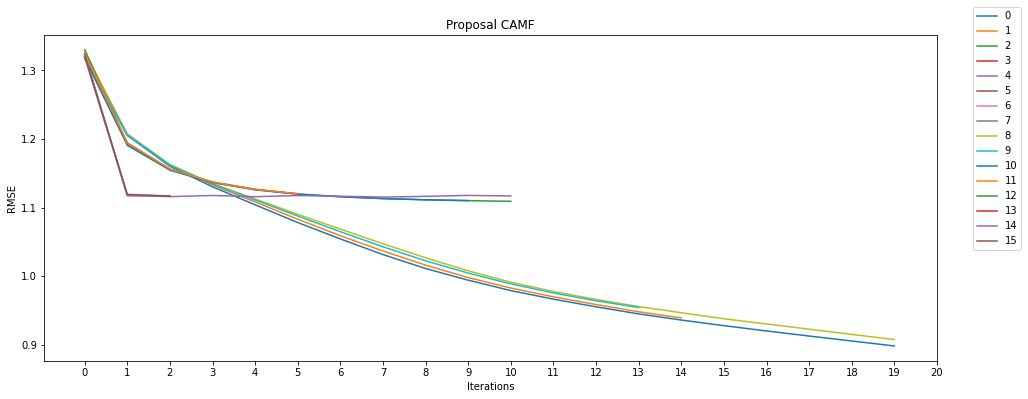

In [38]:
lines = results.History

plt.figure(figsize=(16,6))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))
plt.legend(lines.index,loc='upper right',bbox_to_anchor=(1.1, 1.1))
plt.title('Proposal CAMF')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show();

**Top Three**

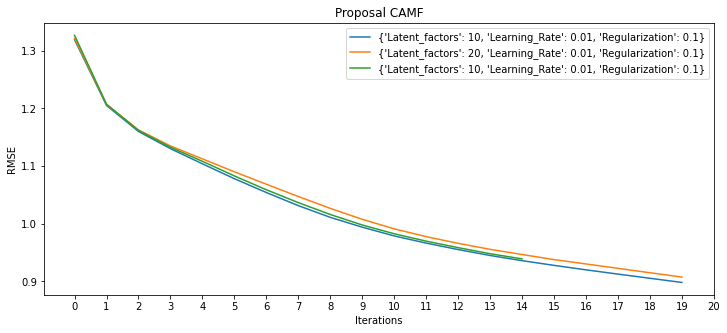

In [39]:
results.loc[results.RMSE.nsmallest(3).index,:]
lines = lines[results.RMSE.nsmallest(3).index]
plt.figure(figsize=(12,5))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))

leg = (results.loc[results.RMSE.nsmallest(3).index,['Latent_factors','Learning_Rate','Regularization']]).T.to_dict().values()
plt.xticks(np.arange(n_iterations[0]+1))
plt.title('Proposal CAMF')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend(leg)
plt.show();

## MF inovation optimization

**Hyperparams search + train the model :**

In [ ]:
n_iterations   = [20] # just one value due to computational power
convergence    = [1e-3,1e-2]  
latent_factors = [10, 20]
regularization = [0.1, 1]
learning_rate  = [0.01, 0.1]

bias_only_results = pd.DataFrame(columns=['Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','History','Time'])

for n_iter in n_iterations:
    for lf in latent_factors:
        for lr in learning_rate:
            for reg in regularization:
                for conv in convergence:

                    dic = {'Iterations':n_iter,'Latent_factors':lf,'Learning_Rate':lr,'Regularization':reg,'Convergence':conv}

                    # initialize model
                    mf = MF(train.values,df_context, n_factors=lf, only_bias=True, context_aware=True)
                    
                    # record training time
                    start = time.time()
                    
                    # train MF
                    mf.fit(n_iterations=n_iter,verbose=False,learning_rate=lr,regularization=reg,convergence=conv)
                    
                    # record traning time
                    dic['Time'] = time.time() - start
                    
                    # eval model
                    # please use the model evaluation funcntions 
                    dic['RMSE'] = mf.get_rmse(test)
                    dic['MRR_5'] = mf.get_mrr(test, k=5)     
                    dic['MRR_10'] = mf.get_mrr(test, k=10)   
                    dic['NDCG_5'] = mf.get_ndcg(test, k=5)   
                    dic['NDCG_10'] = mf.get_ndcg(test, k=10)      
                
                    # record model history
                    dic['History'] = mf.history # model 
                    
                    # add experiment
                    bias_only_results = bias_only_results.append(dic,ignore_index=True)

bias_only_results

**Training History**

In [ ]:
lines = bias_only_results.History

plt.figure(figsize=(16,6))

for l in lines:
    plt.plot(l[0])

plt.xticks(np.arange(n_iterations[0]+1))
plt.legend(lines.index,loc='upper right',bbox_to_anchor=(1.1, 1.1))
plt.title('Only Bias CAMF')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show();

**Top Three**

In [ ]:
lines = bias_only_results.loc[bias_only_results.RMSE.nsmallest(3).index,:]
plt.figure(figsize=(12,5))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))

leg = (bias_only_results.loc[bias_only_results.RMSE.nsmallest(3).index,['Latent_factors','Learning_Rate','Regularization']]).T.to_dict().values()
plt.xticks(np.arange(n_iterations[0]+1))
plt.title('Only Bias CAMF')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend(leg)
plt.show();